# Classification of photon loss state (Fig 8)

In [49]:
import h5py

import numpy as np

import qutip
from qutip import fidelity, Qobj, destroy, expect, coherent
from qutip.wigner import qfunc

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from qst_nn.models.classifier import Classifier
from qst_nn.data.preprocess import remove_data, remap_labels, normalize, add_noise
from qst_nn.training.train_classifier import loss, optimizer
from qst_nn.utils import plot_three_husimi, plot_three_fock, cat
from qst_nn.utils import add_photon_noise


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from tqdm.auto import tqdm


from sklearn.metrics import roc_auc_score, accuracy_score

# from qst_cgan.ops import cat, random_alpha

%load_ext autoreload
%autoreload 2

os.environ["CUDA_VISIBLE_DEVICES"] = ""
tf.keras.backend.set_floatx('float32')

qutip.settings.atol = 1e-6

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set figure option and size

In [10]:
# https://scipy-cookbook.readthedocs.io/items/Matplotlib_LaTeX_Examples.html
fig_width_pt = 246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
params = {# 'backend': 'ps',
          'axes.labelsize': 8,
          'font.size': 8,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'axes.labelpad': 1,
          'text.usetex': False,
          'figure.figsize': fig_size,}
plt.rcParams.update(params)
figpath = "../results/figures/"

# Data for a cat state with |$\alpha$| = 2 under photon loss

In [71]:
hilbert_size = 32
xgrid, ygrid = 32, 32

xvec = np.linspace(-5, 5, xgrid)
yvec = np.linspace(-5, 5, ygrid)

rho = cat(hilbert_size, 3, 0, 0)
tlist = np.linspace(0, 2000, 2000)

photon_loss_states = add_photon_noise(rho, gamma=0.05, tlist=tlist)

In [72]:
nlist = [] # A list to save delta n/n0

state = Qobj(photon_loss_states[0])
n0 = expect(a.dag()*a, state)
xdata = [] # A list to store the generated data for predictions


for k in tqdm(range(0, len(photon_loss_states), 5)):
    state = Qobj(photon_loss_states[k])
    state = state/state.tr()
    data = qfunc(state, xvec, yvec, g=2)
    data = normalize(data)

    data = data.reshape((1, 32, 32, 1))
    n = expect(a.dag()*a, state)
    xdata.append(data)

    delta_n = (n0 - n)/n0    
    nlist.append(delta_n)


nlist = np.array(nlist)
xdata = np.array(xdata).reshape(-1, xgrid, ygrid)

100%|██████████| 400/400 [00:03<00:00, 125.05it/s]


# Plot the data to see the shrinking effect of the photon loss channel

/var/folders/8s/tfpsk_fx609f8w7z__yzz9vh0000gn/T/ipykernel_26598/1895885816.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolor(xvec, yvec, im/np.max(im), vmin=0, vmax=1, cmap="hot")


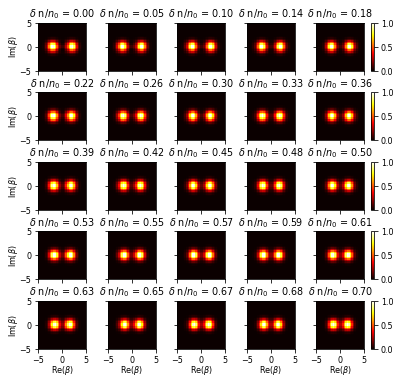

In [73]:
image_grid_size = 5
num_images = 25

# Select a bunch of random indices to get grid x grid images for plotting
rand_indices = np.arange(0, x.shape[0], 4)
images = x[rand_indices]
labels = [r"$\delta$ n/$n_0$ = {:.2f}".format(nlist[i]) for i in rand_indices]


fig = plt.figure(figsize=(10, 6), constrained_layout=False)
image_grid = ImageGrid(fig, 111,  # similar to subplot(111)
                       nrows_ncols=(image_grid_size, image_grid_size),
                       cbar_mode="edge",
                       cbar_pad = 0.1,
                       axes_pad=0.3,)
                 

for i in range(num_images):
    ax, im, label = image_grid[i], images[i], labels[i]

    im = ax.pcolor(xvec, yvec, im/np.max(im), vmin=0, vmax=1, cmap="hot")
    ax.set_title(label)
    ax.cax.colorbar(im, ticks=[0, 0.5, 1])
    ax.set_ylabel(r"Im($\beta$)")
    ax.set_xlabel(r"Re($\beta$)")

plt.show()

# Load the saved model

In [74]:
classifier = Classifier()
classifier.compile(optimizer=optimizer,
                   loss=loss,
                   metrics=['accuracy'])



# Load the model weights
checkpoint_path = "classifier/"
checkpoint_dir = os.path.dirname(checkpoint_path)
classifier.load_weights(checkpoint_path)

# Predict classes for a lossy cat state

In [75]:
pred = classifier.predict(xdata.reshape((-1, 32, 32, 1)))
probabilities_softmax = tf.keras.activations.softmax(tf.convert_to_tensor(pred))

# Predicted probabilities for each of the seven classes for 400 different 
# data points of lossy cat states

print(probabilities_softmax.shape) 

(400, 7)


# Plot the predictions

Since we only show one plot, we do not have any mean and std. However, we can
repeat the code to generate plots for different random cat states and plot the
mean and std of the probabilities. 

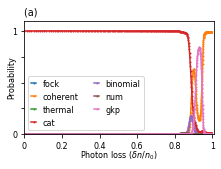

In [76]:
reverse_mapping_correct = {
          0:"fock",
         1:"coherent",
         2:"thermal",
         3:"cat",
         4:"binomial",
         5:"num",
         6:"gkp"
          }

fig, ax1 = plt.subplots(1, 1, figsize=(fig_width, fig_height))

xlist = nlist.ravel()
mean = probabilities_softmax

for i in range(7):
    ax1.plot(xlist, mean[:, i], "-o", alpha = 1, markersize=1,
             label="{}".format(reverse_mapping_correct[i]))
    # ax1.fill_between(xlist, mean[:, i] - std[:, i],
    #                 mean[:, i] + std[:, i], alpha=0.1)

ax1.legend(loc="lower left", ncol=2, handlelength=.6)
# ax1.grid(alpha=0.3)

ax1.set_xlabel(r"Photon loss ($\delta n$/$n_0$)",)
ax1.set_ylabel(r"Probability", labelpad=-4,)


ax1.set_ylim(-0.001, 1.1)
ax1.set_xlim(-0.001, 1.01)
ax1.set_yticks([0, 0.25, 0.5, 0.75, 1.])

ax1.set_yticklabels([0, "", "", "", 1])
ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax1.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])

ax1.set_aspect(0.55)
# ax1.set_title(r"(a)", loc="left")
ax1.set_title("(a)                                                           ")
# ax1.text(0.02, .83, "(a)")

plt.show()

5
['cat', 'cat', 'coherent']


/Users/shahnawaz/Dropbox/phd/tomography/manuscript/code/qst-nn/qst_nn/utils.py:234: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[0].pcolor(xvec, yvec, d1,
/Users/shahnawaz/Dropbox/phd/tomography/manuscript/code/qst-nn/qst_nn/utils.py:238: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[1].pcolor(xvec, yvec, d2,
/Users/shahnawaz/Dropbox/phd/tomography/manuscript/code/qst-nn/qst_nn/utils.py:242: MatplotlibDeprecationWarning: shading='flat' when 

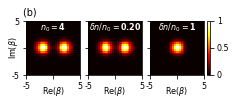

In [77]:
psi = coherent(32, 2) + coherent(32, -2)
psi = psi.unit()
rho = psi*psi.dag()


tlist = np.linspace(0, 3500, 500)

states_list_photon_loss = add_photon_noise(rho, gamma=0.08, tlist=tlist)

# start, mid, end = 0, int(len(tlist)/2), -1
start, end = 0, -1

mid = 5
end = -1

im1 = normalize(qfunc(rho, xvec, yvec, g=2))
im2 = normalize(qfunc(states_list_photon_loss[mid], xvec, yvec, g=2))
im3 = normalize(qfunc(states_list_photon_loss[end], xvec, yvec, g=2))

x = np.array([im1, im2, im3]).reshape((-1, 32, 32, 1))
predictions = np.argmax(classifier.predict(x), 1)
                                      
fig, ax = plot_three_husimi(im1, im2, im3, cmap="hot",
                            title="(b)                                                           ")

predicted_labels = [reverse_mapping_correct[label] for label in predictions]

bbox=dict(boxstyle='square, pad=0.01', fc='None', ec='None')
textcolor= "white"

n0 = expect(a.dag()*a, rho)
n1 = expect(a.dag()*a, states_list_photon_loss[mid])
n2 = expect(a.dag()*a, states_list_photon_loss[end])


intext = [r"$n_0 = ${:.0f}".format(n0),
          r"$\delta n/n_0 = ${:.2f}".format((n0 - n1)/n0),
          r"$\delta n/n_0 = ${:.0f}".format((n0 - n2)/n0)]



ax[0].text(0.5, 0.83, intext[0], bbox=bbox, ha='center',
      transform=ax[0].transAxes, fontsize=8, color=textcolor, fontweight="bold")

for i in range(1,3):
    ax[i].text(0.5, 0.83, intext[i], bbox=bbox, ha='center',
          transform=ax[i].transAxes, fontsize=8, color=textcolor,fontweight="bold")

plt.show()

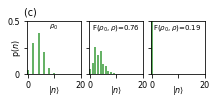

In [78]:


fig, ax = plot_three_fock(rho, states_list_photon_loss[mid],
                states_list_photon_loss[end],
                title="(c)                                                           ")


intext = [r"$\rho_0$",
          r"F($\rho_0, \rho$)="+"{:.2f}".format(fidelity(rho, states_list_photon_loss[mid])),
          r"F($\rho_0, \rho$)="+"{:.2f}".format(fidelity(rho, states_list_photon_loss[end]))]



textcolor="black"
ax[0].text(0.5, 0.87, intext[0], bbox=bbox, ha='center',
      transform=ax[0].transAxes, fontsize=7, color=textcolor, )

for i in range(1,3):
    ax[i].text(0.5, 0.85, intext[i], bbox=bbox, ha='center',
          transform=ax[i].transAxes, fontsize=7, color=textcolor,)

plt.show()

# Plots for all the data in the paper

If you have the full data file for all photon loss states (~5 GB), you can use
the code below to get a mean and std plot for the predicted probabilities.

Please contact "shahnawaz.ahmed95@gmail.com" for the full data files.

In [79]:
datapath = "data/"
fname = "photon_loss_states_cat_restricted-2-0.h5"

with h5py.File(datapath+fname, 'r') as f:
    states_list = f["states"][:100]


probabilities = []
photon_numbers = []

a = destroy(hilbert_size)


for i, states in enumerate(states_list[:100]):
    plist = []
    nlist = []

    state = Qobj(states[0])

    n0 = expect(a.dag()*a, state)
    x = []

    for k in tqdm(range(0, len(states), 5)):
        state = Qobj(states[k])
        state = state/state.tr()
        data = qfunc(state, xvec, yvec, g=2)
        data = normalize(data)
        data = data.reshape((1, 32, 32, 1))
        n = expect(a.dag()*a, state)
        x.append(data)
        delta_n = (n0 - n)/n0
        
        nlist.append(delta_n)

    x = np.array(x).reshape((-1, 32, 32, 1))
    
    probabilities.append(classifier.predict(x))
    photon_numbers.append(nlist)

100%|██████████| 100/100 [00:00<00:00, 135.03it/s]


In [82]:
probabilities_softmax = tf.keras.activations.softmax(tf.convert_to_tensor(probabilities))
photon_numbers = np.array(photon_numbers)
mean = np.mean(probabilities_softmax, axis=0)
std = np.std(probabilities_softmax, axis=0)

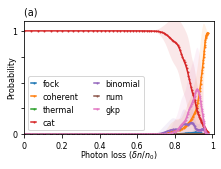

In [83]:
fig, ax1 = plt.subplots(1, 1, figsize=(fig_width, fig_height))

xlist = photon_numbers[0].ravel()
for i in range(7):
    ax1.plot(xlist, mean[:, i], "-o", alpha = 1, markersize=1,
             label="{}".format(reverse_mapping_correct[i]))
    ax1.fill_between(xlist, mean[:, i] - std[:, i],
                    mean[:, i] + std[:, i], alpha=0.1)

ax1.legend(loc="lower left", ncol=2, handlelength=.6)
# ax1.grid(alpha=0.3)

ax1.set_xlabel(r"Photon loss ($\delta n$/$n_0$)",)
ax1.set_ylabel(r"Probability", labelpad=-4,)


ax1.set_ylim(-0.001, 1.1)
ax1.set_xlim(-0.001, 1.01)
ax1.set_yticks([0, 0.25, 0.5, 0.75, 1.])

ax1.set_yticklabels([0, "", "", "", 1])
ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax1.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])

ax1.set_aspect(0.55)
# ax1.set_title(r"(a)", loc="left")
ax1.set_title("(a)                                                           ")
# ax1.text(0.02, .83, "(a)")

plt.show()